# Load and Pre-process

In [1]:
import pandas as pd

# load original dataset
df_original_dataset = pd.read_csv('../data/raw/ALLFEATURES.CSV')

# find missing values, if any, and display findings
if (df_original_dataset.isnull().values.any()):
    null_columns = df_original_dataset.columns[df_original_dataset.isnull().any()]
    # find number of missing values per column
    print(df_original_dataset[null_columns].isnull().sum())
    # find rows with missing values
    print(df_original_dataset[df_original_dataset.isnull().any(axis=1)][null_columns].head())

# copy original dataset
df_dataset_labels = df_original_dataset.copy()
original_df_size = df_dataset_labels.shape[0]
# replace NaN with 0
# df_dataset_labels.fillna(0, inplace=True)

# drop the rows with NaN
df_dataset_labels = df_dataset_labels.dropna(axis='index')

print("\n{} instances were dropped because they had at least one feature with a NaN value\n".format(
original_df_size - df_dataset_labels.shape[0]))

# create label based on building name
labels = [] # empty list that will hold each label and will add as an extra column
# Based on Clayton Miller's Doctoral Thesis, Figure 3.13, page 37. Labels can be extracted from the building name
for index, row in df_dataset_labels.iterrows():
    if "Office" in row[0]:
        labels.append("Office")
    elif "PrimClass" in row[0]:
        labels.append("PrimClass")
    elif "UnivClass" in row[0]:
        labels.append("UnivClass")
    elif "UnivDorm" in row[0]:
        labels.append("UnivDorm")
    elif "UnivLab" in row[0]:
        labels.append("UnivLab")

# add the new column
df_dataset_labels['Labels'] = labels
# drop the building names (first column)
del df_dataset_labels['Unnamed: 0']


BG_consumpstats_maxhrtout        1
BG_jmotif_inclasssim_24_6_6      1
BG_jmotiftemporal_24_6_6_max     1
BG_jmotiftemporal_24_6_6_mean    1
BG_jmotiftemporal_24_6_6_min     1
BG_jmotiftemporal_24_6_6_std     1
dtype: int64
    BG_consumpstats_maxhrtout  BG_jmotif_inclasssim_24_6_6  \
73                        NaN                     0.170204   
89                       34.0                          NaN   

    BG_jmotiftemporal_24_6_6_max  BG_jmotiftemporal_24_6_6_mean  \
73                      2.883726                      -0.348559   
89                           NaN                            NaN   

    BG_jmotiftemporal_24_6_6_min  BG_jmotiftemporal_24_6_6_std  
73                     -1.332862                       0.64821  
89                           NaN                           NaN  

2 instances were dropped because they had at least one feature with a NaN value



In [2]:
# show the new dataset
print(df_dataset_labels)

     BG_all_meanvs95_max  BG_all_meanvs95_mean  BG_all_meanvs95_min  \
0               0.991726              0.830303             0.553791   
1               0.980135              0.681228             0.416167   
2               0.976661              0.736467             0.504575   
3               0.967693              0.676260             0.399966   
4               0.991130              0.905865             0.813399   
5               0.977206              0.689762             0.320276   
6               0.952980              0.694542             0.308460   
7               0.963807              0.553636             0.197003   
8               0.963152              0.676798             0.316245   
9               0.957164              0.631584             0.469574   
10              0.984613              0.788902             0.541719   
11              0.983196              0.841899             0.688620   
12              0.955242              0.771034             0.577163   
13    

## Label Histogram

In [3]:
import plotly.graph_objs as go

hist = go.FigureWidget(
    data=[
        dict(
            type='histogram',
            x=df_dataset_labels.iloc[:,-1],
        )
    ]
)


In [4]:
hist


FigureWidget({
    'data': [{'type': 'histogram',
              'uid': '05b33951-ec73-4d3d-a998-4793c5f02548',…

In [35]:
hist.layout.title = 'Primary-Space-Use (PSU) Histogram'

# User-defined Functions and Variables

In [36]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.plotly as py
from collections import Counter
from scipy.spatial.distance import cdist

# models
from sklearn.ensemble import RandomForestClassifier

# training and feature selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import model_selection
from sklearn import tree
from sklearn import linear_model

DEFAULT_K = 10 # default number of folds

# Determine number of folds
def chooseK(train_labels):
    classCounter = Counter(train_labels)
    numLeastCommonClass = min(classCounter.values())
    return min(numLeastCommonClass, DEFAULT_K)

# Choose the best combination of parameters for a given model
def selectModelParameters(train_vectors, train_labels, trainclf, parameters, scorer, useSampleWeight = False):
    k = chooseK(train_labels) # get number of folds
    print "Number of folds: " + str(k)
    stratifiedKFold = StratifiedKFold(n_splits = k)
    if useSampleWeight:
        n_samples = len(train_labels)
        n_classes = len(set(train_labels))
        classCounter = Counter(train_labels)
        sampleWeights = [n_samples / (n_classes * classCounter[label]) for label in train_labels]
        gridSearch = GridSearchCV(clf, parameters, 
                                  cv = stratifiedKFold, 
                                  scoring = scorer, 
                                  fit_params = {'sample_weight' : sampleWeights})
    else:
        gridSearch = GridSearchCV(clf, parameters, cv = stratifiedKFold, scoring = scorer)
    
    gridSearch.fit(train_vectors, train_labels)
    print "Best parameters set found on development set:"
    print gridSearch.best_params_
    print "\nGrid scores on development set using " + scorer + " : "
    for params, mean_score, scores in gridSearch.grid_scores_:
        print "%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params)
    
    return gridSearch.best_estimator_

# Choose the optimal depth of a tree model 
def chooseOptimalTreeDepth(clf, train_vectors, train_labels, plot = True):
    # generate a list of potential depths to calculate the optimal
    depths = list(range(1, 25))

    # empty list that will hold cv scores
    cv_scores = []

    # find optimal tree depth
    for d in depths: # TODO: try using chooseK(train_labels) instead of jus DEFAULT_K
        clf_depth = clf.set_params(max_depth = d) # use previous parameters while changing depth
        scores = cross_val_score(clf_depth, train_vectors, train_labels, 
                                 cv = chooseK(train_labels), 
                                 scoring = 'accuracy') # accuracy here is f1 micro
        cv_scores.append(scores.mean())

    # changing to misclassification error and determining best depth
    MSE = [1 - x for x in cv_scores] # MSE = 1 - f1_micro
    optimal_depth = depths[MSE.index(min(MSE))]
    print "The optimal depth is: ", optimal_depth, "\n"
    print "Expected accuracy (f1 micro) based on Cross-Validation: ", cv_scores[depths.index(optimal_depth)], "\n"
    
    if plot:
        # plot misclassification error vs depths
        fig = plt.figure(figsize=(12, 10))
        plt.plot(depths, MSE)
        plt.xlabel('Tree Depth', fontsize = 20)
        plt.ylabel('Misclassification Error', fontsize = 20)
        plt.legend(fontsize = 15)
        plt.show()

    return optimal_depth

# Calculate different metrics such as f1-micro, f1-macro, confusion matrix, and the classification report
def getClfMetrics(test_labels, pred_labels):
    acc = accuracy_score(test_labels, pred_labels) 
    print "\nAccuracy (f1 micro) on test set: ", acc
    print "F1 micro on test set: ", f1_score(test_labels, pred_labels, average = 'micro')
    print "F1 macro on test set: ", f1_score(test_labels, pred_labels, average = 'macro')
    print "\nConfusion Matrix: "
    print confusion_matrix(y_test, y_pred)#, labels = [-2, -1, 0, 1, 2])
    print "\nClassification Metrics: "
    print classification_report(test_labels, pred_labels)
    return acc

import numpy as np
import random

def clusterKmedoids(distances, k=3):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)
   
    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point. 
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters, curr_medoids

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    clusters[medoids] = medoids
    return clusters

def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

SyntaxError: invalid syntax (<ipython-input-36-6a0be14b2865>, line 43)

In [6]:
# feature related variables
feature_set = list(df_dataset_labels)[:-1] # don't count the target label
num_feature_set = len(feature_set)
print "Number of Features: " + str(num_feature_set)

# create design matrix X and target vector y
X = np.array(df_dataset_labels.iloc[:, 0:num_feature_set])
y = np.array(df_dataset_labels['Labels'])

# split into train and test
test_size_percentage = 0.3 

# X_train = train + cv set (train_vectors)
# X_test = test set (test_vectors)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size_percentage, 
                                                    random_state = 100, stratify = y)

Number of Features: 315


# Classification Algorithms

## Random Forrest (all features)

In [7]:
# run different random forest models with different parameters
parameters = {'n_estimators' : [10, 100, 1000],
              'criterion' : ['entropy', 'gini'],
              'min_samples_split' : [2, 10, 20, 30], 
              'class_weight' : ['balanced', 'balanced_subsample']}
scorer = 'f1_micro'
clf = RandomForestClassifier(n_estimators = 10, min_samples_split = 2, class_weight = 'balanced', random_state = 100)
rf_classifier = selectModelParameters(X_train, y_train, clf, parameters, scorer)

Number of folds: 10
Best parameters set found on development set:
{'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}

Grid scores on development set using f1_micro : 
0.796 (+/-0.095) for {'min_samples_split': 2, 'n_estimators': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.875 (+/-0.088) for {'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.864 (+/-0.070) for {'min_samples_split': 2, 'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.768 (+/-0.135) for {'min_samples_split': 10, 'n_estimators': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.850 (+/-0.046) for {'min_samples_split': 10, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.873 (+/-0.052) for {'min_samples_split': 10, 'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.754 (+/-0.142) for {'min_samples_split': 20, 'n_estimators': 10, 'c

/opt/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning:

The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20



The optimal depth is:  11 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8798779012014306 



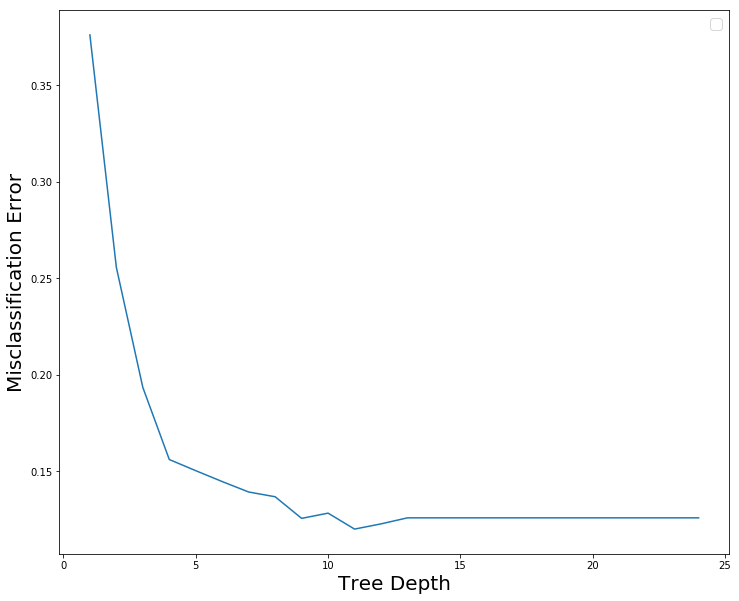

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=11, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False)

Accuracy (f1 micro) on test set:  0.881578947368421
F1 micro on test set:  0.881578947368421
F1 macro on test set:  0.8768723705218721

Confusion Matrix: 
[[43  2  0  0  1]
 [ 2 30  0  0  0]
 [ 3  2 16  1  2]
 [ 0  0  1 19  1]
 [ 3  0  0  0 26]]

Classification Metrics: 
             precision    recall  f1-score   support

     Office       0.84      0.93      0.89        46
  PrimClass       0.88      0.94      0.91        32
  UnivClass       0.94      0.67      0.78        24
   UnivDorm       0.95      0.90      0.93        21
    UnivLab       0.87      0.90 

In [8]:
# find optimal tree depth and generate model
optimal_depth = chooseOptimalTreeDepth(rf_classifier, X_train, y_train)

# generate the model with the selected parameters plus the optimal depth and do the model fitting
rf_optimal = rf_classifier.set_params(max_depth = optimal_depth)
print rf_optimal
rf_optimal.fit(X_train, y_train)

# predict the response on test set
y_pred = rf_optimal.predict(X_test) 

# get metrics
rf_acc = getClfMetrics(y_test, y_pred)


**Gini Index:**

$$G = \sum_{i=1}^{n_c} p_i(1-p_i)$$

Importance using Scikit-Learn:

$$ I= G_{parent} − G_{split_1} − G_{split_2} $$

References:

https://stats.stackexchange.com/questions/92419/relative-importance-of-a-set-of-predictors-in-a-random-forests-classification-in

https://www.fs.fed.us/rm/pubs_other/rmrs_2008_moisen_g001.pdf


In [9]:
# find feature importance
# reference: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_optimal.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_optimal.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [10]:
# choose top N features
n_features = 20 # change accordingly
indices_n_features = indices[:n_features]

# get top features' name based on index
indices_names = []
for feature in np.nditer(indices.copy(order='C')):
#     print feature
    indices_names.append(df_dataset_labels.columns.values[feature])

# top N features name
indices_names_n = indices_names[:n_features]

# print df_dataset_labels.columns.values
print "Top {} important feature indeces:\n {} \n".format(n_features, indices_n_features)
print "Feature names:\n {}".format(indices_names_n)

Top 20 important feature indeces:
 [199 200 203 233  90  50 165 279 226   3 197  53 220 207 198 221 205 206
 247 290] 

Feature names:
 ['BG_jmotif_inclasssim_168_8_21', 'BG_jmotif_inclasssim_24_12_12', 'BG_jmotiftemporal_168_6_14_max', 'BG_normalizedcons_min', 'BG_consumpstatsdaykw', 'BG_consumpstats_dailykwmaxvar', 'BG_eemeter_cvrmse', 'BG_stlweeklypattern_sun_mean', 'BG_loadshape_mape_interval_daytime', 'BG_all_meanvs95_std', 'BG_hourlystats_maxHOD', 'BG_consumpstats_kw90', 'BG_jmotiftemporal_24_8_8_mean', 'BG_jmotiftemporal_168_8_21_max', 'BG_jmotif_inclasssim_168_6_14', 'BG_jmotiftemporal_24_8_8_min', 'BG_jmotiftemporal_168_6_14_min', 'BG_jmotiftemporal_168_6_14_std', 'BG_stats_minhrkw', 'BG_weekdays_meanvsmax_std']


In [11]:
# Define the plotly figure
import plotly.graph_objs as go

fig_all_features = go.FigureWidget(
    data=[
        dict(
            type='bar',
            x=indices_names,
            y=importances[indices],

        )
    ],
)


fig_top20_features = go.FigureWidget(
    data=[
        dict(
            type='bar',
            x=indices_names_n,
            y=importances[indices_n_features],

        )
    ],
)


In [12]:
# All features
fig_all_features


RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3sndHlwZSc6ICdiYXInLAogICAgICAgICAgICAgICd1aWQnOiAnYWM5ZWMwOTgtZDg2Yi0xMWU4LThmMGYtMDJmNjMwMTViYjFjJywKICAgICDigKY=


In [13]:
# Adjust plot properties
fig_all_features.layout.title = "All " + str(len(indices)) + " Features"
fig_all_features.layout.xaxis.tickangle = 40
fig_all_features.layout.xaxis.ticktext = indices_n_features
fig_all_features.layout.margin.l = 40
fig_all_features.layout.margin.r = 150
fig_all_features.layout.margin.t = 40
fig_all_features.layout.margin.b = 150

In [14]:
# Plot figure
fig_top20_features


RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3sndHlwZSc6ICdiYXInLAogICAgICAgICAgICAgICd1aWQnOiAnYWNhNDc3NTQtZDg2Yi0xMWU4LThmMGYtMDJmNjMwMTViYjFjJywKICAgICDigKY=


In [15]:
# Adjust plot properties
# fig_top20_features.layout.title = "Top " + str(n_features) + " Features"
fig_top20_features.layout.title = None
fig_top20_features.layout.xaxis.tickangle = 40
fig_top20_features.layout.xaxis.ticktext = indices_n_features
fig_top20_features.layout.margin.l = 40
fig_top20_features.layout.margin.r = 150
fig_top20_features.layout.margin.t = 40
fig_top20_features.layout.margin.b = 160


## What do the features mean?

1. Statistical Temporal features for different time windows: (seasons, weeks, etc)
    - mean, median, maximum, minimum, range, variance, standard deviation, and ratios
2. Pattern-based
    - motifs (pattern that is frequently found in the dataset) (e.g. interesting behaviour)
    - discords (unusual pattern that diverges from the rest of the dataset) (e.g. infrequent behaviour)
    
    Symbolic Aggregate approXimation (SAX) is used to discretize the dataset and use motif and discords algos
    (SAX daily windows)
    
jmotif_inclasssim_168_8_21= jMotif in-class similarity on a 168 hour sliding window 8 segments of 21 hours each
The in-class similarity/specificity is calculated (page 76) with SAX-VSM and tf-idf. This basically determines how similar the building is to the specific label it has been assigned to
    

## Removing all 'in-class' features

In [16]:
# find columns without the "inclass" substring
columns_no_inclass = [c for c in df_dataset_labels.columns if "inclass" not in c]
# copy the dataset
df_dataset_labels_no_inclass = df_dataset_labels.copy()
# only retain the columns WITHOUT inclass features
df_dataset_labels_no_inclass = df_dataset_labels[columns_no_inclass]
print "Original feature set size: {}\nNew feature set size: {}\n".format(df_dataset_labels.shape[1], 
                                                                            df_dataset_labels_no_inclass.shape[1])

Original feature set size: 316
New feature set size: 311



## Random Forrest (subset of features-no inclass)

In [17]:
# rerun all experiments from above but without inclass similarities
# feature related variables
feature_set = list(df_dataset_labels_no_inclass)[:-1] # don't count the target label
num_feature_set = len(feature_set)
print "Number of Features: " + str(num_feature_set)

# create design matrix X and target vector y
X = np.array(df_dataset_labels_no_inclass.iloc[:, 0:num_feature_set])
y = np.array(df_dataset_labels_no_inclass['Labels'])

# split into train and test
test_size_percentage = 0.3 

# X_train = train + cv set (train_vectors)
# X_test = test set (test_vectors)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size_percentage, 
                                                    random_state = 100, stratify = y)

Number of Features: 310


In [18]:
# run different random forest models with different parameters
parameters = {'n_estimators' : [10, 100, 1000],
              'criterion' : ['entropy', 'gini'],
              'min_samples_split' : [2, 10, 20, 30], 
              'class_weight' : ['balanced', 'balanced_subsample']}
scorer = 'f1_micro'
clf_no_inclass = RandomForestClassifier(n_estimators = 10, min_samples_split = 2, class_weight = 'balanced', random_state = 100)
rf_classifier_no_inclass = selectModelParameters(X_train, y_train, clf_no_inclass, parameters, scorer)

Number of folds: 10
Best parameters set found on development set:
{'min_samples_split': 20, 'n_estimators': 1000, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}

Grid scores on development set using f1_micro : 
0.691 (+/-0.155) for {'min_samples_split': 2, 'n_estimators': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.722 (+/-0.100) for {'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.714 (+/-0.122) for {'min_samples_split': 2, 'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.666 (+/-0.132) for {'min_samples_split': 10, 'n_estimators': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.728 (+/-0.141) for {'min_samples_split': 10, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.731 (+/-0.118) for {'min_samples_split': 10, 'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.700 (+/-0.133) for {'min_samples_split': 20, 'n_estimators

/opt/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning:

The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20



The optimal depth is:  12 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7439025432040138 



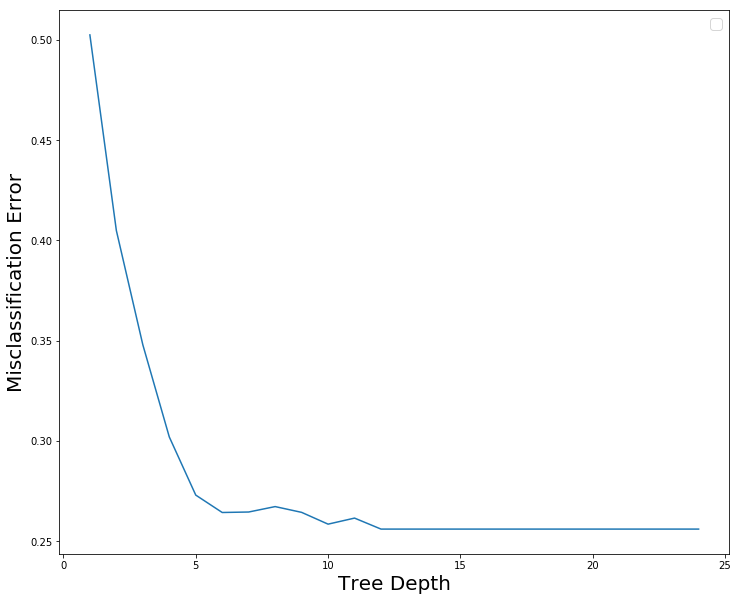

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False)

Accuracy (f1 micro) on test set:  0.7894736842105263
F1 micro on test set:  0.7894736842105263
F1 macro on test set:  0.7917857142857143

Confusion Matrix: 
[[37  2  1  0  6]
 [ 3 29  0  0  0]
 [ 6  0 13  0  5]
 [ 0  0  1 19  1]
 [ 4  0  3  0 22]]

Classification Metrics: 
             precision    recall  f1-score   support

     Office       0.74      0.80      0.77        46
  PrimClass       0.94      0.91      0.92        32
  UnivClass       0.72      0.54      0.62        24
   UnivDorm       1.00      0.90      0.95        21
    UnivLab       0.65

In [19]:
# find optimal tree depth and generate model
optimal_depth = chooseOptimalTreeDepth(rf_classifier_no_inclass, X_train, y_train)

# generate the model with the selected parameters plus the optimal depth and do the model fitting
rf_optimal_no_inclass = rf_classifier_no_inclass.set_params(max_depth = optimal_depth)
print rf_optimal_no_inclass
rf_optimal_no_inclass.fit(X_train, y_train)

# predict the response on test set
y_pred = rf_optimal_no_inclass.predict(X_test) 

# get metrics
rf_acc_no_inclass = getClfMetrics(y_test, y_pred)


In [20]:
# find feature importance
# reference: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_optimal_no_inclass.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_optimal_no_inclass.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# choose top N features
n_features = 20 # change accordingly
indices_n_features = indices[:n_features]

# get top N features' name based on index
indices_names_n = []
for feature in np.nditer(indices_n_features.copy(order='C')):
#     print feature
    indices_names_n.append(df_dataset_labels_no_inclass.columns.values[feature])

print "Top {} important feature indeces:\n {} \n".format(n_features, indices_n_features)
print "Feature names:\n {}".format(indices_names_n)

Top 20 important feature indeces:
 [274  53 198 197 215 228  87 221  50 202  90 248 200 211  72 209 201 271
  71 281] 

Feature names:
 ['BG_stlweeklypattern_sun_mean', 'BG_consumpstats_kw90', 'BG_jmotiftemporal_168_6_14_max', 'BG_hourlystats_maxHOD', 'BG_jmotiftemporal_24_8_8_mean', 'BG_normalizedcons_min', 'BG_consumpstats_t10kw', 'BG_loadshape_mape_interval_daytime', 'BG_consumpstats_dailykwmaxvar', 'BG_jmotiftemporal_168_8_21_max', 'BG_consumpstatsdaykw', 'BG_stlreminder_aug_mean', 'BG_jmotiftemporal_168_6_14_min', 'BG_jmotiftemporal_24_6_6_mean', 'BG_consumpstats_kwvarsummer', 'BG_jmotiftemporal_24_12_12_std', 'BG_jmotiftemporal_168_6_14_std', 'BG_stlweeklypattern_fri_mean', 'BG_consumpstats_kwvar', 'BG_weekdays_meanvs95_std']


In [21]:
# Define the plotly figure
import plotly.graph_objs as go

fig_top20_features_no_sim = go.FigureWidget(
    data=[
        dict(
            type='bar',
            x=indices_names_n,
            y=importances[indices_n_features],

        )
    ],
)

fig_top20_features_no_sim

RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3sndHlwZSc6ICdiYXInLAogICAgICAgICAgICAgICd1aWQnOiAnNjg5MWM1ODAtZDg3MC0xMWU4LThmMGYtMDJmNjMwMTViYjFjJywKICAgICDigKY=


In [22]:
# Adjust plot properties
# fig_top20_features_no_sim.layout.title = "Top " + str(n_features) + " Features"
fig_top20_features_no_sim.layout.title = None
fig_top20_features_no_sim.layout.xaxis.tickangle = 40
fig_top20_features_no_sim.layout.xaxis.ticktext = indices_n_features
fig_top20_features_no_sim.layout.margin.l = 40
fig_top20_features_no_sim.layout.margin.r = 150
fig_top20_features_no_sim.layout.margin.t = 40
fig_top20_features_no_sim.layout.margin.b = 150


## Write features indeces to txt files

In [23]:
file_name = str(n_features) + "_features_sub.txt"
output_file = open(file_name, "w")
# write the indices of the most N important features
print >> output_file, "\n".join(str(j) for j in indices_n_features)
output_file.close()

## Removing all 'motif' features

In [24]:
# find columns without the "inclass" substring
columns_no_inclass_motif = [c for c in df_dataset_labels_no_inclass.columns if "motif" not in c]
# copy the dataset
df_dataset_labels_no_inclass_motif = df_dataset_labels_no_inclass.copy()
# only retain the columns WITHOUT inclass features
df_dataset_labels_no_inclass_motif = df_dataset_labels_no_inclass_motif[columns_no_inclass_motif]
print "Original feature set size: {}\nNew feature set size: {}\n".format(df_dataset_labels_no_inclass.shape[1], 
                                                                            df_dataset_labels_no_inclass_motif.shape[1])

Original feature set size: 311
New feature set size: 291



## Random Forrest (subset of features-no inclass, motif)

In [25]:
# rerun all experiments from above but without inclass similarities
# feature related variables
feature_set = list(df_dataset_labels_no_inclass_motif)[:-1] # don't count the target label
num_feature_set = len(feature_set)
print "Number of Features: " + str(num_feature_set)

# create design matrix X and target vector y
X = np.array(df_dataset_labels_no_inclass_motif.iloc[:, 0:num_feature_set])
y = np.array(df_dataset_labels_no_inclass_motif['Labels'])

# split into train and test
test_size_percentage = 0.3 

# X_train = train + cv set (train_vectors)
# X_test = test set (test_vectors)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size_percentage, 
                                                    random_state = 100, stratify = y)

Number of Features: 290


In [26]:
# run different random forest models with different parameters
parameters = {'n_estimators' : [10, 100, 1000],
              'criterion' : ['entropy', 'gini'],
              'min_samples_split' : [2, 10, 20, 30], 
              'class_weight' : ['balanced', 'balanced_subsample']}
scorer = 'f1_micro'
clf_no_inclass_motif= RandomForestClassifier(n_estimators = 10, min_samples_split = 2, class_weight = 'balanced', random_state = 100)
rf_classifier_no_inclass_motif = selectModelParameters(X_train, y_train, clf_no_inclass_motif, parameters, scorer)

Number of folds: 10
Best parameters set found on development set:
{'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'gini', 'class_weight': 'balanced'}

Grid scores on development set using f1_micro : 
0.640 (+/-0.118) for {'min_samples_split': 2, 'n_estimators': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.677 (+/-0.118) for {'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.674 (+/-0.146) for {'min_samples_split': 2, 'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.629 (+/-0.138) for {'min_samples_split': 10, 'n_estimators': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.674 (+/-0.101) for {'min_samples_split': 10, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.669 (+/-0.110) for {'min_samples_split': 10, 'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.626 (+/-0.100) for {'min_samples_split': 20, 'n_estimators': 10, 'crit

/opt/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning:

The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20



The optimal depth is:  14 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6968829147137972 



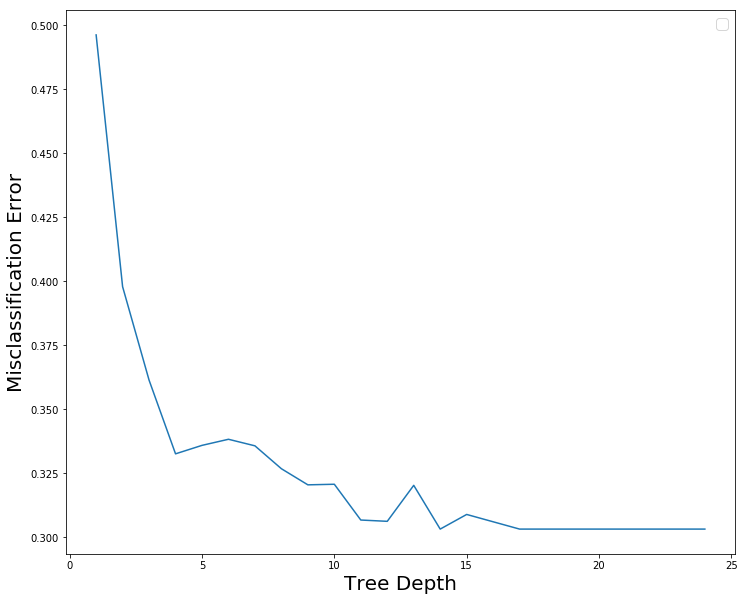

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=14, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False)

Accuracy (f1 micro) on test set:  0.7105263157894737
F1 micro on test set:  0.7105263157894737
F1 macro on test set:  0.6771554683819666

Confusion Matrix: 
[[37  1  2  0  6]
 [ 2 30  0  0  0]
 [16  1  3  1  3]
 [ 0  0  1 19  1]
 [ 9  0  1  0 19]]

Classification Metrics: 
             precision    recall  f1-score   support

     Office       0.58      0.80      0.67        46
  PrimClass       0.94      0.94      0.94        32
  UnivClass       0.43      0.12      0.19        24
   UnivDorm       0.95      0.90      0.93        21
    UnivLab       0.66      0.66  

In [27]:
# find optimal tree depth and generate model
optimal_depth = chooseOptimalTreeDepth(rf_classifier_no_inclass_motif, X_train, y_train)

# generate the model with the selected parameters plus the optimal depth and do the model fitting
rf_optimal_no_inclass_motif = rf_classifier_no_inclass_motif.set_params(max_depth = optimal_depth)
print rf_optimal_no_inclass_motif
rf_optimal_no_inclass_motif.fit(X_train, y_train)

# predict the response on test set
y_pred = rf_optimal_no_inclass_motif.predict(X_test) 

# get metrics
rf_acc_no_inclass_motif = getClfMetrics(y_test, y_pred)


In [28]:
# find feature importance
# reference: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_optimal_no_inclass_motif.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_optimal_no_inclass_motif.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# choose top N features
n_features = 20 # change accordingly
indices_n_features = indices[:n_features]

# get top N features' name based on index
indices_names_n = []
for feature in np.nditer(indices_n_features.copy(order='C')):
#     print feature
    indices_names_n.append(df_dataset_labels_no_inclass_motif.columns.values[feature])

print "Top {} important feature indeces:\n {} \n".format(n_features, indices_n_features)
print "Feature names:\n {}".format(indices_names_n)

Top 20 important feature indeces:
 [ 53 254  87 208 197 251  71 165 265 232 228 222  90 201  50 255  14  93
  52 198] 

Feature names:
 ['BG_consumpstats_kw90', 'BG_stlweeklypattern_sun_mean', 'BG_consumpstats_t10kw', 'BG_normalizedcons_min', 'BG_hourlystats_maxHOD', 'BG_stlweeklypattern_fri_mean', 'BG_consumpstats_kwvar', 'BG_eemeter_cvrmse', 'BG_weekdays_meanvsmax_std', 'BG_stlreminder_jul_mean', 'BG_stlreminder_aug_mean', 'BG_stats_minhrkw', 'BG_consumpstatsdaykw', 'BG_loadshape_mape_interval_daytime', 'BG_consumpstats_dailykwmaxvar', 'BG_stlweeklypattern_thur_mean', 'BG_all_minvsmax_min', 'BG_consumpstatst_90kw', 'BG_consumpstats_dailykwvar', 'BG_loadshape_corr_interval']


In [29]:
# Define the plotly figure
import plotly.graph_objs as go

fig_top_10_features_no_motif_sim = go.FigureWidget(
    data=[
        dict(
            type='bar',
            x=indices_names_n,
            y=importances[indices_n_features],

        )
    ],
)

fig_top_10_features_no_motif_sim

RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3sndHlwZSc6ICdiYXInLAogICAgICAgICAgICAgICd1aWQnOiAnMWU2NmQ3OWEtZDg3My0xMWU4LThmMGYtMDJmNjMwMTViYjFjJywKICAgICDigKY=


In [30]:
# Adjust plot properties
# fig_top_10_features_no_motif_sim.layout.title = "Top " + str(n_features) + " Features"
fig_top_10_features_no_motif_sim.layout.title = None
fig_top_10_features_no_motif_sim.layout.xaxis.tickangle = 40
fig_top_10_features_no_motif_sim.layout.xaxis.ticktext = indices_n_features
fig_top_10_features_no_motif_sim.layout.margin.l = 40
fig_top_10_features_no_motif_sim.layout.margin.r = 150
fig_top_10_features_no_motif_sim.layout.margin.t = 40
fig_top_10_features_no_motif_sim.layout.margin.b = 170


In [31]:

file_name = str(n_features) + "_features_sub.txt"
output_file = open(file_name, "w")
# write the indices of the most N important features
print >> output_file, "\n".join(str(j) for j in indices_n_features)
output_file.close()

## Removing 'stl' features

In [32]:
# find columns without the "inclass" substring
columns_no_inclass_motif_stl = [c for c in df_dataset_labels_no_inclass_motif.columns if "stl" not in c]
# copy the dataset
df_dataset_labels_no_inclass_motif_stl = df_dataset_labels_no_inclass_motif.copy()
# only retain the columns WITHOUT inclass features
df_dataset_labels_no_inclass_motif_stl = df_dataset_labels_no_inclass_motif[columns_no_inclass_motif_stl]
print "Original feature set size: {}\nNew feature set size: {}\n".format(df_dataset_labels_no_inclass_motif.shape[1], 
                                                                         df_dataset_labels_no_inclass_motif_stl.shape[1])

Original feature set size: 291
New feature set size: 260



## Random Forrest (subset of features-no inclass, motif, stl)

In [33]:
# rerun all experiments from above but without inclass similarities
# feature related variables
feature_set = list(df_dataset_labels_no_inclass_motif_stl)[:-1] # don't count the target label
num_feature_set = len(feature_set)
print "Number of Features: " + str(num_feature_set)

# create design matrix X and target vector y
X = np.array(df_dataset_labels_no_inclass_motif_stl.iloc[:, 0:num_feature_set])
y = np.array(df_dataset_labels_no_inclass_motif_stl['Labels'])

# split into train and test
test_size_percentage = 0.3 

# X_train = train + cv set (train_vectors)
# X_test = test set (test_vectors)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size_percentage, 
                                                    random_state = 100, stratify = y)

Number of Features: 259


In [34]:
# run different random forest models with different parameters
parameters = {'n_estimators' : [10, 100, 1000],
              'criterion' : ['entropy', 'gini'],
              'min_samples_split' : [2, 10, 20, 30], 
              'class_weight' : ['balanced', 'balanced_subsample']}
scorer = 'f1_micro'
clf_no_inclass_motif_stl= RandomForestClassifier(n_estimators = 10, min_samples_split = 2, class_weight = 'balanced', random_state = 100)
rf_classifier_no_inclass_motif_stl = selectModelParameters(X_train, y_train, clf_no_inclass_motif, parameters, scorer)

Number of folds: 10
Best parameters set found on development set:
{'min_samples_split': 20, 'n_estimators': 1000, 'criterion': 'gini', 'class_weight': 'balanced'}

Grid scores on development set using f1_micro : 
0.615 (+/-0.110) for {'min_samples_split': 2, 'n_estimators': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.669 (+/-0.107) for {'min_samples_split': 2, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.677 (+/-0.121) for {'min_samples_split': 2, 'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.635 (+/-0.103) for {'min_samples_split': 10, 'n_estimators': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.674 (+/-0.122) for {'min_samples_split': 10, 'n_estimators': 100, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.666 (+/-0.106) for {'min_samples_split': 10, 'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced'}
0.615 (+/-0.122) for {'min_samples_split': 20, 'n_estimators': 10, 'cr

/opt/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning:

The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20



The optimal depth is:  12 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6906729614450203 



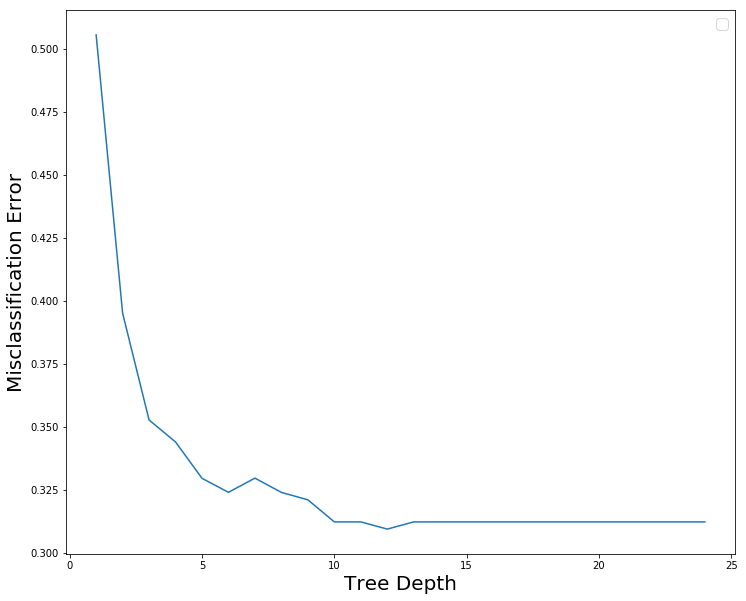

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=100,
            verbose=0, warm_start=False)

Accuracy (f1 micro) on test set:  0.6973684210526315
F1 micro on test set:  0.6973684210526315
F1 macro on test set:  0.677660225952909

Confusion Matrix: 
[[34  2  3  0  7]
 [ 2 30  0  0  0]
 [12  2  5  0  5]
 [ 0  0  1 19  1]
 [ 8  0  2  1 18]]

Classification Metrics: 
             precision    recall  f1-score   support

     Office       0.61      0.74      0.67        46
  PrimClass       0.88      0.94      0.91        32
  UnivClass       0.45      0.21      0.29        24
   UnivDorm       0.95      0.90      0.93        21
    UnivLab       0.58      0.62 

In [35]:
# find optimal tree depth and generate model
optimal_depth = chooseOptimalTreeDepth(rf_classifier_no_inclass_motif_stl, X_train, y_train)

# generate the model with the selected parameters plus the optimal depth and do the model fitting
rf_optimal_no_inclass_motif_stl = rf_classifier_no_inclass_motif_stl.set_params(max_depth = optimal_depth)
print rf_optimal_no_inclass_motif_stl
rf_optimal_no_inclass_motif_stl.fit(X_train, y_train)

# predict the response on test set
y_pred = rf_optimal_no_inclass_motif_stl.predict(X_test) 

# get metrics
rf_acc_no_inclass_motif_stl = getClfMetrics(y_test, y_pred)


In [36]:
# find feature importance
# reference: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_optimal_no_inclass_motif_stl.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_optimal_no_inclass_motif_stl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# choose top N features
n_features = 10 # change accordingly
indices_n_features = indices[:n_features]

# get top N features' name based on index
indices_names_n = []
for feature in np.nditer(indices_n_features.copy(order='C')):
#     print feature
    indices_names_n.append(df_dataset_labels_no_inclass_motif.columns.values[feature])

print "Top {} important feature indeces:\n {} \n".format(n_features, indices_n_features)
print "Feature names:\n {}".format(indices_names_n)

Top 10 important feature indeces:
 [ 53  87 197 208 165  71 198  73  50 201] 

Feature names:
 ['BG_consumpstats_kw90', 'BG_consumpstats_t10kw', 'BG_hourlystats_maxHOD', 'BG_normalizedcons_min', 'BG_eemeter_cvrmse', 'BG_consumpstats_kwvar', 'BG_loadshape_corr_interval', 'BG_consumpstats_kwvarwinter', 'BG_consumpstats_dailykwmaxvar', 'BG_loadshape_mape_interval_daytime']


In [37]:
# Define the plotly figure
import plotly.graph_objs as go

fig_top_10_features_no_motif_sim_stl = go.FigureWidget(
    data=[
        dict(
            type='bar',
            x=indices_names_n,
            y=importances[indices_n_features],

        )
    ],
)

fig_top_10_features_no_motif_sim_stl

RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3sndHlwZSc6ICdiYXInLAogICAgICAgICAgICAgICd1aWQnOiAnODIwOTVkYTAtZDg3Ny0xMWU4LThmMGYtMDJmNjMwMTViYjFjJywKICAgICDigKY=


In [38]:
# Adjust plot properties
fig_top_10_features_no_motif_sim_stl.layout.title = "Top " + str(n_features) + " Features"
fig_top_10_features_no_motif_sim_stl.layout.xaxis.tickangle = 40
fig_top_10_features_no_motif_sim_stl.layout.xaxis.ticktext = indices_n_features
fig_top_10_features_no_motif_sim_stl.layout.margin.l = 40
fig_top_10_features_no_motif_sim_stl.layout.margin.r = 150
fig_top_10_features_no_motif_sim_stl.layout.margin.t = 40
fig_top_10_features_no_motif_sim_stl.layout.margin.b = 170


In [39]:
file_name = str(n_features) + "_features_sub.txt"
output_file = open(file_name, "w")
# write the indices of the most N important features
print >> output_file, "\n".join(str(j) for j in indices_n_features)
output_file.close()

# Removing outliers

Using the feature set, without any motif features, the dendogram using the InCHlib was build.
<img src="dendogram_no_motif.png">
As we can see, however the dendograms still look unbalanced, there are some branches were some splits only contains a couple of buildings.

## K = number of use-type buildings

### K-means

In [48]:
# Reference: https://sebastianraschka.com/Articles/2014_about_feature_scaling.html#z-score-standardization-or-min-max-scaling

# feature related variables
feature_set = list(df_dataset_labels_no_inclass_motif_stl)[:-1] # don't count the target label
num_feature_set = len(feature_set)
print "Number of Features: " + str(num_feature_set)

# create design matrix X and target vector y, and scale X to zero mean and unit variance
X = np.array(df_dataset_labels_no_inclass_motif_stl.iloc[:, 0:num_feature_set])
std_scaled = StandardScaler().fit(X)
X_scaled = std_scaled.transform(X)
y = np.array(df_dataset_labels_no_inclass_motif_stl['Labels'])

num_labels = len(set(y))
print "Number of labels: {}\n".format(num_labels)

# build Kmeans model
n_clusters = num_labels
kmeans_5 = KMeans(n_clusters=n_clusters, n_init=100, max_iter=300, random_state=100)
cluster_5_labels = kmeans_5.fit_predict(X_scaled)


Number of Features: 259
Number of labels: 5



**Cluster metrics:**
The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.


For k_clusters = 5
The average silhouette_score is : 0.167097447816


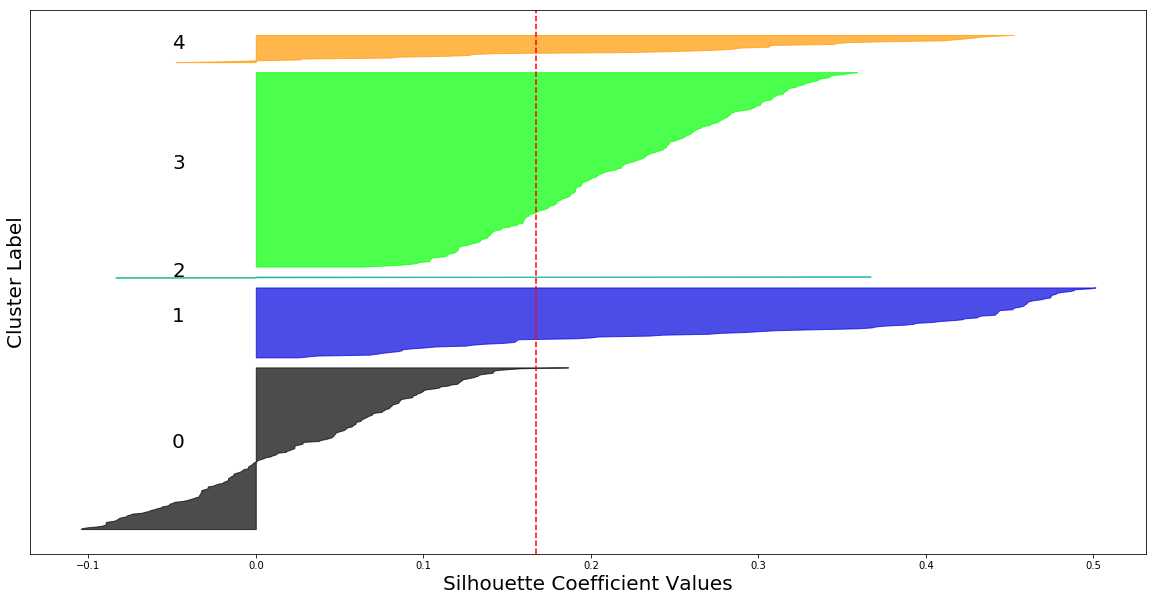

In [49]:
# Reference: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(X_scaled, cluster_5_labels)
print "For k_clusters = {}\nThe average silhouette_score is : {}".format(n_clusters, silhouette_avg)

# plot variables
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
# ax.set_xlim([-0.2, 1])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, cluster_5_labels)

y_lower = 10
      
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_5_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 20)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

# ax.set_title("Silhouette plot for the various clusters.", fontsize = 18)
ax.set_xlabel("Silhouette Coefficient Values", fontsize = 20)
ax.set_ylabel("Cluster Label", fontsize = 20)

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])  # Clear the yaxis labels / ticks
# ax.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [42]:
# get number of elements in each cluster
X_scaled_dict = {i: np.where(cluster_5_labels == i)[0] for i in range(n_clusters)}

X_scaled_clustered_5 = []
for key, value in X_scaled_dict.iteritems():
    temp = [key,value]
    X_scaled_clustered_5.append(temp)

print X_scaled_clustered_5

elements_in_clusters = map(len, X_scaled_dict.values())

elements_cluster_5_bar = go.FigureWidget(
    data=[
        dict(
            type='bar',
            x=[0, 1, 2, 3, 4],
            y=elements_in_clusters,
        )
    ],
)

elements_cluster_5_bar

[[0, array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  13,  14,  18,  19,
        21,  22,  24,  25,  28,  33,  35,  36,  43,  45,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  60,  62,  66,  68,  69,
        70,  71,  73,  75,  76,  77,  79,  80,  83,  84,  85,  86,  87,
        88,  91,  92,  94,  96, 100, 101, 103, 104, 105, 109, 111, 115,
       116, 122, 123, 126, 128, 132, 137, 140, 142, 144, 145, 146, 148,
       149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 188, 192, 206, 209, 228, 233, 237, 245, 257,
       263, 265, 268, 270, 271, 272, 274, 276, 279, 280, 281, 282, 285,
       286, 288, 289, 290, 294, 295, 300, 306, 310, 311, 313, 323, 327,
       328, 330, 331, 333, 334, 335, 336, 338, 340, 356, 364, 368, 369,
       370, 374, 380, 381, 382, 383, 384, 387, 388, 399, 409, 410, 415,
       423, 426, 437, 441, 448, 463, 464, 475, 486, 498])],

RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3sndHlwZSc6ICdiYXInLAogICAgICAgICAgICAgICd1aWQnOiAnODMyMGI5ZjQtZDg3Ny0xMWU4LThmMGYtMDJmNjMwMTViYjFjJywKICAgICDigKY=


In [30]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

# count histogram of true labels in each k-means cluster
for i in range(0, 5):
    clusters = X_scaled_clustered_5[i][1] # the second element are the indeces, the first one is the given cluster
    clusters_labels = [y[j] for j in clusters]
    
    # get count for each true label
    values, counts = np.unique(clusters_labels, return_counts=True)
    
    true_labels_clusters = go.FigureWidget(
        data=[
            dict(
                type='bar',
                x=values,
                y=counts,
            )
        ],
    )
    
    plotly.offline.iplot(true_labels_clusters)

    


NameError: name 'X_scaled_clustered_5' is not defined

### K-medoids

K-medoids minimizes the sum of dissimilarities between points labeled to be in a cluster and a point designated as the center of that cluster. In contrast to the k-means algorithm, k-medoids chooses datapoints as centers
(Ref: http://www.math.le.ac.uk/people/ag153/homepage/KmeansKmedoids/Kmeans_Kmedoids.html)


## Find best K based on metrics

### K-means

For n_clusters = 2 The average silhouette_score is : 0.2653479504403328
For n_clusters = 3 The average silhouette_score is : 0.3012498870198559
For n_clusters = 4 The average silhouette_score is : 0.16641012581408549
For n_clusters = 5 The average silhouette_score is : 0.16753703149894056
For n_clusters = 6 The average silhouette_score is : 0.14866308139864848


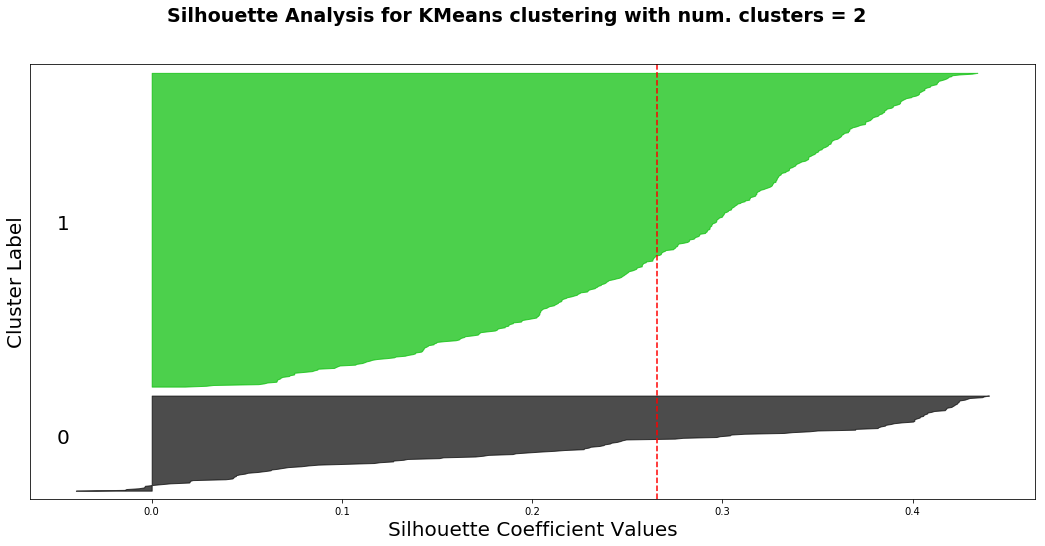

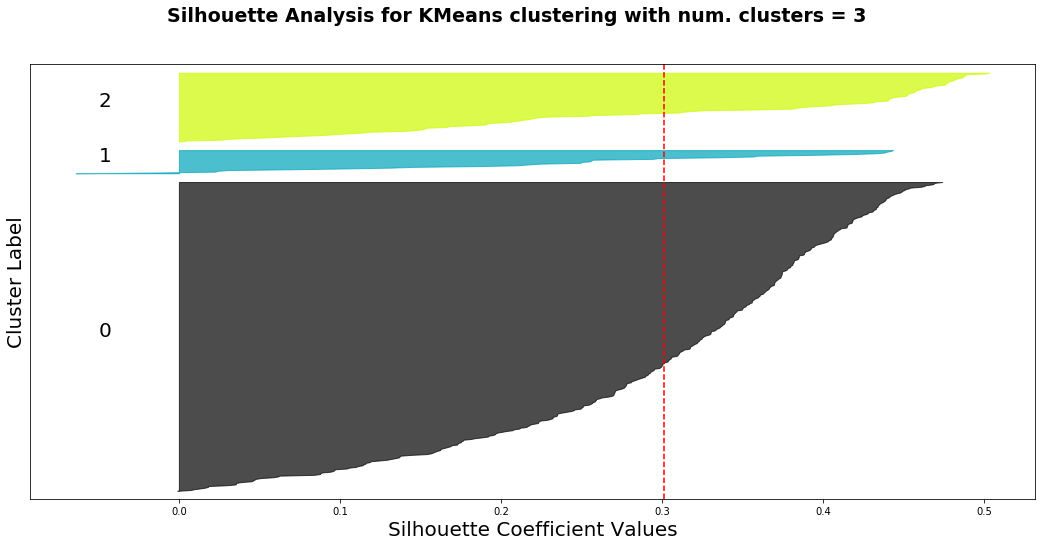

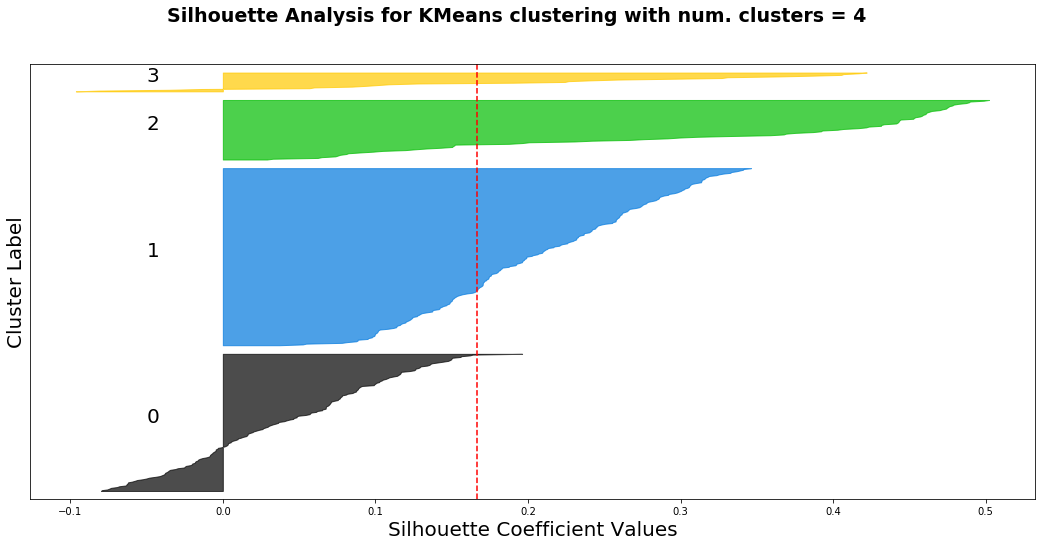

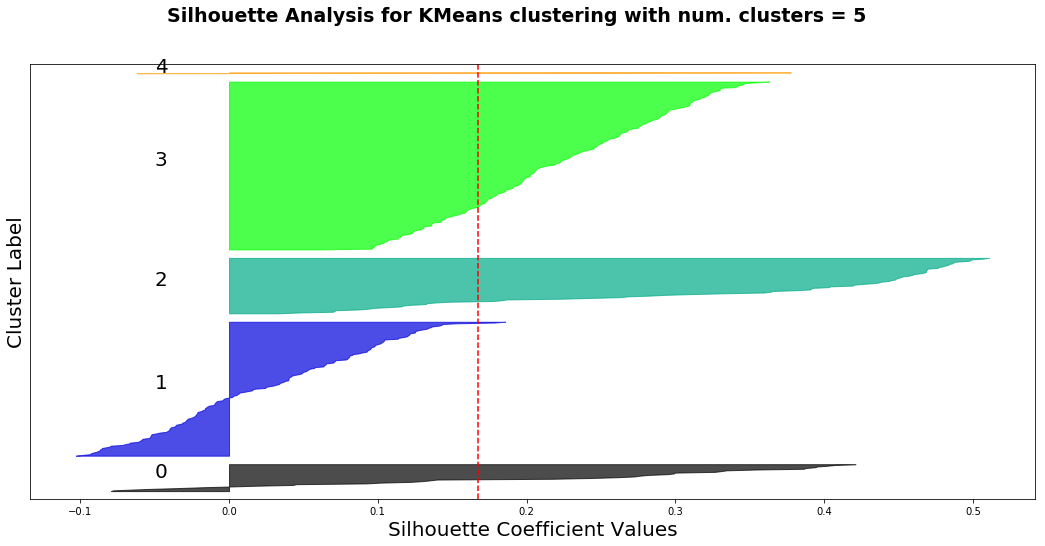

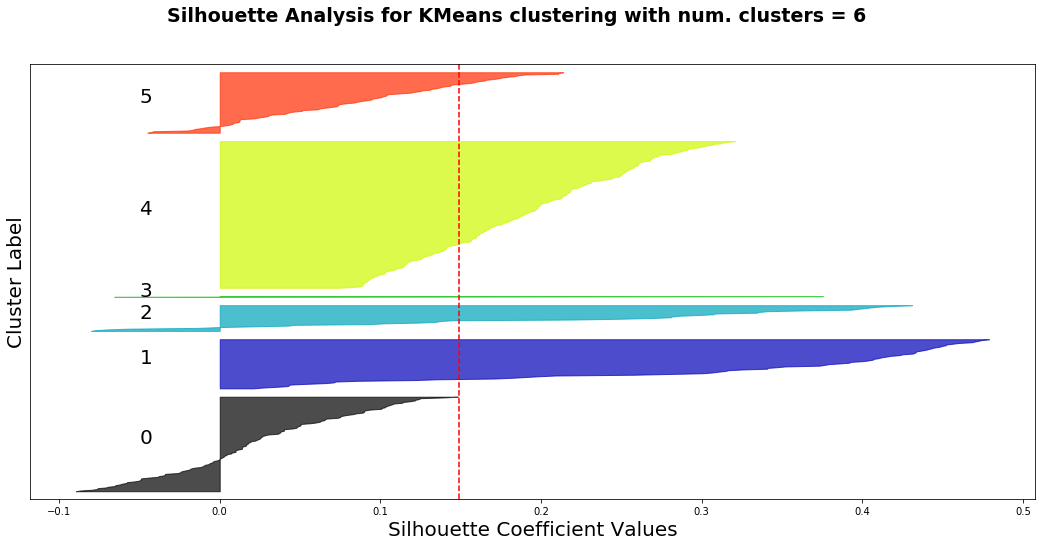

In [50]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig = plt.figure(figsize=(18,8))
    ax = fig.add_subplot(1, 1, 1)

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=100)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print "For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 20)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

#     ax.set_title("The silhouette plot for the various clusters.", fontsize = 18)
    ax.set_xlabel("Silhouette Coefficient Values", fontsize = 20)
    ax.set_ylabel("Cluster Label", fontsize = 20)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    
    plt.suptitle(("Silhouette Analysis for KMeans clustering "
                  "with num. clusters = %d" % n_clusters),
                 fontsize=19, fontweight='bold')

plt.show()

## Elbow Method

Number of Features: 259
Number of labels: 5



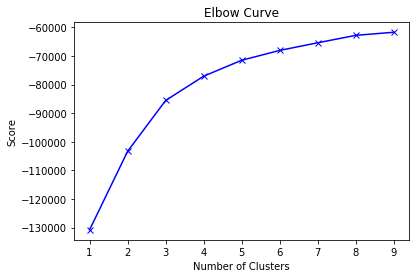

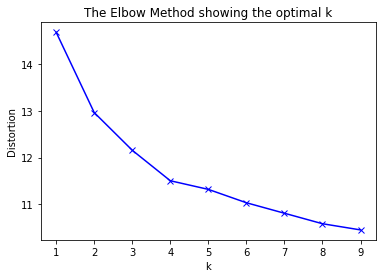

In [45]:
# feature related variables
feature_set = list(df_dataset_labels_no_inclass_motif_stl)[:-1] # don't count the target label
num_feature_set = len(feature_set)
print "Number of Features: " + str(num_feature_set)

# create design matrix X and target vector y, and scale X to zero mean and unit variance
X = np.array(df_dataset_labels_no_inclass_motif_stl.iloc[:, 0:num_feature_set])
std_scaled = StandardScaler().fit(X)
X_scaled = std_scaled.transform(X)
y = np.array(df_dataset_labels_no_inclass_motif_stl['Labels'])

num_labels = len(set(y))
print "Number of labels: {}\n".format(num_labels)

# k means determine k
distortions = []
score = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=100).fit(X_scaled)
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])
    score.append(kmeanModel.score(X_scaled))

plt.plot(K, score, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### K-medoids

K-medoids minimizes the sum of dissimilarities between points labeled to be in a cluster and a point designated as the center of that cluster. In contrast to the k-means algorithm, k-medoids chooses datapoints as centers
(Ref: http://www.math.le.ac.uk/people/ag153/homepage/KmeansKmedoids/Kmeans_Kmedoids.html)

Code:
Bauckhage C. Numpy/scipy Recipes for Data Science: k-Medoids Clustering[R]. Technical Report, University of Bonn, 2015.

## Hierarchical Clustering

https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

show that label is, not arbitrary, but is not a good indicator of the behaviour, and we can quantify that